# 문제 6

(kaggle 형 문제) **prob4**를 바탕으로 아래 데이터셋을 만든다.

. **prob6_train**: DateHour 변수 기준으로 2021년 8월 14일 전(8월 14일 미포함) 데이터 (행의 수: 5256개)

. **prob6_test**: DateHour 변수 기준으로 2021년 8월 14일 이후(8월 14일 포함) 데이터 (행의 수: 744 개)

일 때, **prob6_train**으로 target을 예측하는 모델을 만들어, 

**prob6_test**의 target에 대한 MAE를 최소화하는 모델을 만든다. 

$MAE(Y, \hat{Y})=\frac{1}{n}\sum^n_{i=1}|y_i - \hat{y_i}|$ 

**prob6_test**의 예측 결과를 아래와 같은 형식으로 출력한다. 파일명은 answer6.csv 이다.

|DateHour|TotalHour|
|--------|---------|
|2021-08-14 00:00:00|102.607580|
|2021-08-14 01:00:00|94.078890|
....

※ 실제 상황에 가까운 연습을 위해 **prob6_test**의 target 값은 모른다는 상황을 가정하고 문제를 푼다.
_kaggle 노트에서 이어 갑니다.

## 데이터 전처리

In [15]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
#import mlxtend
import sys
#import xgboost as xgb

print(sys.version)
for i in [pd, np, sklearn, scipy, statsmodels]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
statsmodels 0.11.1


In [16]:
df_elec = pd.read_csv('elec.csv', parse_dates=['Date', 'DateHour'])
df_info = pd.read_csv('info.csv')
df_info['Date'] = pd.to_datetime(df_info['Date'])

In [17]:
df_elec1 = df_elec.pivot(
    index='DateHour', 
    columns='Minute', 
    values='Value').reset_index() # index에 위치한 DateHour를 컬럼에 위치시킵니다
df_elec1

Minute,DateHour,15분,30분,45분,60분
0,2021-01-01 00:00:00,62,61,61,61
1,2021-01-01 01:00:00,96,93,116,113
2,2021-01-01 02:00:00,106,96,106,107
3,2021-01-01 03:00:00,92,110,110,109
4,2021-01-01 04:00:00,108,105,106,108
...,...,...,...,...,...
6163,2021-09-14 19:00:00,152,151,171,139
6164,2021-09-14 20:00:00,124,130,128,130
6165,2021-09-14 21:00:00,134,130,125,124
6166,2021-09-14 22:00:00,100,109,120,114


In [18]:
holi = pd.to_datetime(["2021-01-01", "2021-02-11", "2021-02-12", "2021-03-01", "2021-05-05", "2021-05-19", "2021-08-16"]).date

# pd.Series.dt accessor를 통해 파생 변수들을 만듭니다.
df_elec1 = df_elec1.assign(
    DayName = df_elec1['DateHour'].dt.weekday, 
    Hour = df_elec1['DateHour'].dt.hour,
    AM = (df_elec1['DateHour'].dt.hour >= 12).astype('int'),
    Weekend_yn = df_elec1['DateHour'].dt.weekday.isin([5, 6]).astype('int'),
    Holiday_yn = df_elec1['DateHour'].dt.date.isin(holi).astype('int'), # df_elec1['DateHour'].dt.date는 pd.Series 입니다.
    Avg = df_elec1[['15분', '30분', '45분', '60분']].mean(axis=1),
    TotalHour = df_elec1[['15분', '30분', '45분', '60분']].sum(axis=1),
)

In [19]:
df_info1 = df_info.fillna(0)

In [20]:
df_basetable1 = df_elec1.merge(
    df_info1, 
    left_on='DateHour', 
    right_on='Date', how='inner'
).drop(columns='Date') # DateHour가 컬럼에 있으므로 DateHour, Date 모두 존재하여, Date는 삭제했습니다.
display(df_basetable1.head())
df_basetable1.shape

,DateHour,15분,30분,45분,60분,DayName,Hour,AM,Weekend_yn,Holiday_yn,Avg,TotalHour,생산량,기온,풍속,습도,강수량,전기요금(계절),공장인원,인건비
0,2021-01-01 00:00:00,62,61,61,61,4,0,0,0,1,61.25,245,0,-3.2,2.4,71,0.0,109.8,0.0,1.5
1,2021-01-01 01:00:00,96,93,116,113,4,1,0,0,1,104.50,418,0,-4.5,1.5,77,0.0,109.8,0.0,1.5
2,2021-01-01 02:00:00,106,96,106,107,4,2,0,0,1,103.75,415,0,-3.9,2.6,58,0.0,109.8,0.0,1.5
3,2021-01-01 03:00:00,92,110,110,109,4,3,0,0,1,105.25,421,0,-4.1,2.6,56,0.0,109.8,0.0,1.5
4,2021-01-01 04:00:00,108,105,106,108,4,4,0,0,1,106.75,427,0,-4.6,2.6,60,0.0,109.8,0.0,1.5


(6168, 20)

In [21]:
# shift를 이용합니다.
df_prob3 = df_basetable1.sort_values('DateHour').reset_index(drop=True)
df_prob3['target'] = df_prob3['TotalHour'].shift(-24)
df_prob4 = pd.concat(
    [df_prob3] + [
        df_prob3['TotalHour'].shift(24 * i).rename('lag_{}'.format(i)) for i in range(1, 7)
    ], axis=1
).dropna()
df_prob4.head()

,DateHour,15분,30분,45분,60분,DayName,Hour,AM,Weekend_yn,Holiday_yn,...,전기요금(계절),공장인원,인건비,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
144,2021-01-07 00:00:00,22,22,22,25,3,0,0,0,0,...,109.8,0.000000,1.5,252.0,96.0,96.0,271.0,88.0,253.0,245.0
145,2021-01-07 01:00:00,26,22,22,22,3,1,0,0,0,...,109.8,0.369565,1.5,396.0,85.0,85.0,432.0,99.0,418.0,418.0
146,2021-01-07 02:00:00,22,21,21,22,3,2,0,0,0,...,109.8,0.000000,1.5,411.0,85.0,85.0,439.0,88.0,415.0,415.0
147,2021-01-07 03:00:00,22,22,22,23,3,3,0,0,0,...,109.8,0.629213,1.5,398.0,90.0,90.0,426.0,88.0,421.0,421.0
148,2021-01-07 04:00:00,22,26,26,23,3,4,0,0,0,...,109.8,2.865979,1.5,420.0,93.0,93.0,435.0,95.0,427.0,427.0


In [22]:
# shift를 사용하지 않고 target를 구하는 방법입니다. (값을 구하기만 하고, 따로 prob4로 만들지는 않았습니다.)
df_basetable1.join(
    df_basetable1[['DateHour','TotalHour']].assign(
        DateHour=lambda x: x['DateHour'] - pd.Timedelta(days=1)
    ).set_index('DateHour').rename(columns={'TotalHour': 'target'}),
    on='DateHour', how='inner'
)

,DateHour,15분,30분,45분,60분,DayName,Hour,AM,Weekend_yn,Holiday_yn,...,TotalHour,생산량,기온,풍속,습도,강수량,전기요금(계절),공장인원,인건비,target
0,2021-01-01 00:00:00,62,61,61,61,4,0,0,0,1,...,245,0,-3.2,2.4,71,0.0,109.8,0.000000,1.5,253
1,2021-01-01 01:00:00,96,93,116,113,4,1,0,0,1,...,418,0,-4.5,1.5,77,0.0,109.8,0.000000,1.5,418
2,2021-01-01 02:00:00,106,96,106,107,4,2,0,0,1,...,415,0,-3.9,2.6,58,0.0,109.8,0.000000,1.5,415
3,2021-01-01 03:00:00,92,110,110,109,4,3,0,0,1,...,421,0,-4.1,2.6,56,0.0,109.8,0.000000,1.5,421
4,2021-01-01 04:00:00,108,105,106,108,4,4,0,0,1,...,427,0,-4.6,2.6,60,0.0,109.8,0.000000,1.5,427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,2021-09-13 19:00:00,162,160,148,122,0,19,1,0,0,...,592,2820,22.3,2.1,78,0.0,167.2,4.763514,1.5,613
6140,2021-09-13 20:00:00,113,122,122,126,0,20,1,0,0,...,483,14,22.2,1.3,78,0.0,167.2,0.028986,1.5,512
6141,2021-09-13 21:00:00,122,131,122,115,0,21,1,0,0,...,490,72,21.9,1.9,77,0.0,167.2,0.146939,1.5,513
6142,2021-09-13 22:00:00,97,108,122,113,0,22,1,0,0,...,440,11,21.7,1.4,77,0.0,167.2,0.025000,1.5,443


In [23]:
# 문제에서 제시한 데이터셋을 만듭니다.
df_prob6_train = df_prob4.loc[df_prob4['DateHour'] < pd.to_datetime('2021-08-14')]
df_prob6_test = df_prob4.loc[df_prob4['DateHour'] >= pd.to_datetime('2021-08-14')]
# 정답 target은 떼어냅니다.
s_kaggle_ans =  df_prob6_test.pop('target') # Kaggle의 정답으로 간주하겠습니다, 실제 시험에서는 공개 되지 않습니다.

In [24]:
# 이 과제의 아킬레스 건 
# 정답을 알 수 있는 결정적인 target의 Data leakage(데이터 누수)가 있습니다.
# 실제 미래의 TotalHour는 알 수 없는 상황이니 이점을 감안하여 진행 부탁드립니다.
(df_prob6_test['TotalHour'].shift(-24) - s_kaggle_ans).dropna()

5400    0.0
5401    0.0
5402    0.0
5403    0.0
5404    0.0
       ... 
6115    0.0
6116    0.0
6117    0.0
6118    0.0
6119    0.0
Length: 720, dtype: float64

# Kaggle형 풀이 단계

Step 0: Kaggle용 데이터셋을 만든다.

Step 1: 검증 방법을 정하고, 검증 루틴을 만듭니다. metric: MAE

Step 2: Baseline 모델을 만듭니다

Step 3: 모델 선택 루틴을 만듭니다.

|DateHour|	TotalHour|
|----|----|
|2021-08-14 00:00:00|	102.607580|
|2021-08-14 01:00:00|	94.078890|
....	

Step 4: 모델 개선 작업을 합니다.



## Step 1: 검증 방법을 정하고, 검증 루틴을 만듭니다.


- 검증 방법 정하기
> 분리 방법: Random, 계층적(Stratfied), 그룹(동일한 그룹 분리가 되지 않게), 시점 기준 분리, ...
>
> 진행 방법
>   * Hold-out (train / valid) => 결과의 편차가 크지 않은 경우
>
>   * cross-validation => n개의 셋으로 나누어, 하나씩 학습제외하고 검증셋 지정하여 n번의 검증을 통해 평균으로 성능 측정
>
>   * Monte Carlo => Hold-out 또는 cv 셋의 구성 달리하며 n번 수행 하는 것 


- ML에 있어 핵심 입니다.

In [25]:
# 분리법: 시점 기준 분리 => 평가 데이터는 2021-08-14 이후 시점으로 구성 된점을 감안
# 진행방법: Hold-out => 일단은 가장 간단한 Hold-out 검정으로 시작합니다. 
#    시점 기준 분리된 경우라 예측 성능의 변동성이 큽니다. 따라서, 한 번의 결과 만으로는 안정적 성능 평가를 기대하기 어렵습니다.
#    검증 방법에 대한 추가 빌드업을 한 다음, 여러 번의 검증으로 안정성을 높여 결과를 뽑아 보겠습니다. 

df_train = df_prob6_train.loc[df_prob6_train['DateHour'] < '2021-07-14']
df_valid = df_prob6_train.loc[df_prob6_train['DateHour'] >= '2021-07-14']
df_train['DateHour'].agg(['min', 'max']), df_valid['DateHour'].agg(['min', 'max'])

(min   2021-01-07 00:00:00
 max   2021-07-13 23:00:00
 Name: DateHour, dtype: datetime64[ns],
 min   2021-07-14 00:00:00
 max   2021-08-13 23:00:00
 Name: DateHour, dtype: datetime64[ns])

In [26]:
X_all = df_prob6_test.columns.tolist()
np.array(X_all)

array(['DateHour', '15분', '30분', '45분', '60분', 'DayName', 'Hour', 'AM',
       'Weekend_yn', 'Holiday_yn', 'Avg', 'TotalHour', '생산량', '기온', '풍속',
       '습도', '강수량', '전기요금(계절)', '공장인원', '인건비', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6'], dtype='<U10')

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error

hist = list()
def eval_model(model_name, reg):
    """
        모델의 인스턴스를 받아 검증 결과(MAE)를 구합니다.
        1. HoldOut 검증 - df_train으로 학습하고
        2. df_valid, df_train 에 대한 예측결과에 대한 MAE를 구합니다.
        3. 주어진 모델명으로 평가 결과를 저장합니다.
        4. 가장 최근의 수행결과를 보여 주어 선택하는데 활용하도록 합니다.
        ※ 더 있으면 좋을 만한 요소들을 추가해봅니다.
    Parameters:
        name: str, 모델의 이름,
        reg: sklearn object, 모델 인스턴스
    Returns: str
        검증 결과(df_valid, df_train의 MAE)
    """
    reg.fit(df_train[X_all], df_train['target'])
    result_str = "Valid: {:.5f}, Train: {:.5f}".format(
        mean_absolute_error(
            df_valid['target'], reg.predict(df_valid[X_all])
        ), mean_absolute_error(
            df_train['target'], reg.predict(df_train[X_all])
        )
    )
    hist.append(
        pd.Series([model_name, result_str], index = ['name', 'result'])
    )
    display(
        pd.DataFrame(hist).groupby('name').last()
    )
    
def select_model(reg):
    """
        1. 전체 학습데이터(df_prob6_train)로 학습을 합니다. 
        2. df_prob6_test에 대한 예측을 합니다.
        3. 예측 결과를 출력양식( DateHour, TotalHour)에 맞춰 csv파일을 만듭니다.
        4. 자가 채점을 위한 예측 결과를 반환합니다.
    Parameters: 
        reg: sklearn object, 모델 인스턴스
    Returns: 1차원 np.ndarray
        예측 결과
    """
    reg.fit(df_prob6_train[X_all], df_prob6_train['target'])
    prd = reg.predict(df_prob6_test[X_all])
    pd.DataFrame({
        'DateHour': df_prob6_test['DateHour'],
        'TotalHour': prd
    }).to_csv('answer6.csv', index=None)
    return prd

## Step2: Baseline Model 모델을 만듭니다.

**Idea**

- 모델
> SVR - kernel - 'rbf', C = 10, gamma = 0.1
  
- 전처리 
> 표준화: 'TotalHour', 'lag_1' ~ 'lag_6' 
>
> 가변수화: 'DayName'
>
>통과: 'AM'

In [60]:
from sklearn.svm import SVR

ct = ColumnTransformer([
    ('std', StandardScaler(), ['TotalHour'] + ['lag_{}'.format(i) for i in range(1, 7)]),
    ('ohe', OneHotEncoder(categories='auto'), ['DayName']),
    ('pt', 'passthrough', ['AM'])
])
reg_svr = make_pipeline(ct, SVR(kernel = 'rbf', C = 10, gamma = 0.1))
eval_model('baseline', reg_svr)

,result
name,
baseline,"Valid: 145.34694, Train: 59.43512"


In [47]:
# Kaggle 루틴의 원리의 이해에 도움을 드리기 위해
# 동일한 과정을 ColumnTransformer와 Pipeline없이 구성해봅니다. 
# 검증 과정에 해당하는 것이고, 
# 선택 과정은 이와 같은 과정으로 데이터를 바꿔서 수행 루틴을 구성해야 합니다.
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder

std_scaler = StandardScaler()
ohe = OneHotEncoder(categories='auto', sparse = False)
X_std= ['TotalHour'] + ['lag_{}'.format(i) for i in range(1, 7)]
X_ohe = ['DayName']
X_pt = ['AM']
std_scaler.fit(df_train[X_std])
ohe.fit(df_train[X_ohe])

reg_svr_direct = SVR(kernel = 'rbf', C = 10, gamma = 0.1)
reg_svr_direct.fit(
    pd.concat([
        pd.DataFrame(std_scaler.transform(df_train[X_std]), index = df_train.index),
        pd.DataFrame(ohe.transform(df_train[X_ohe]), index =df_train.index),
        df_train[X_pt]
    ], axis=1), df_train['target']
)
prd = reg_svr_direct.predict(
    pd.concat([
        pd.DataFrame(std_scaler.transform(df_valid[X_std]), index = df_valid.index),
        pd.DataFrame(ohe.transform(df_valid[X_ohe]), index = df_valid.index),
        df_valid[X_pt]
    ], axis=1)
)

print("Without ColumnTransformer & Pipeline", mean_absolute_error(df_valid['target'], prd)) # 145.34693972591637

Without ColumnTransformer & Pipeline 145.34693972591637


## Step3: 모델 선택

**prob6_test**의 예측 결과를 아래와 같은 형식으로 출력한다. 파일명은 answer6.csv 이다.

|DateHour|TotalHour|
|--------|---------|
|2021-08-14 00:00:00|102.607580|
|2021-08-14 01:00:00|94.078890|

In [66]:
prd = select_model(reg_svr)
print("자가채점", mean_absolute_error(s_kaggle_ans, prd))

자가채점 28.571764715699633


## Step 4:  모델 개선 작업을 합니다.


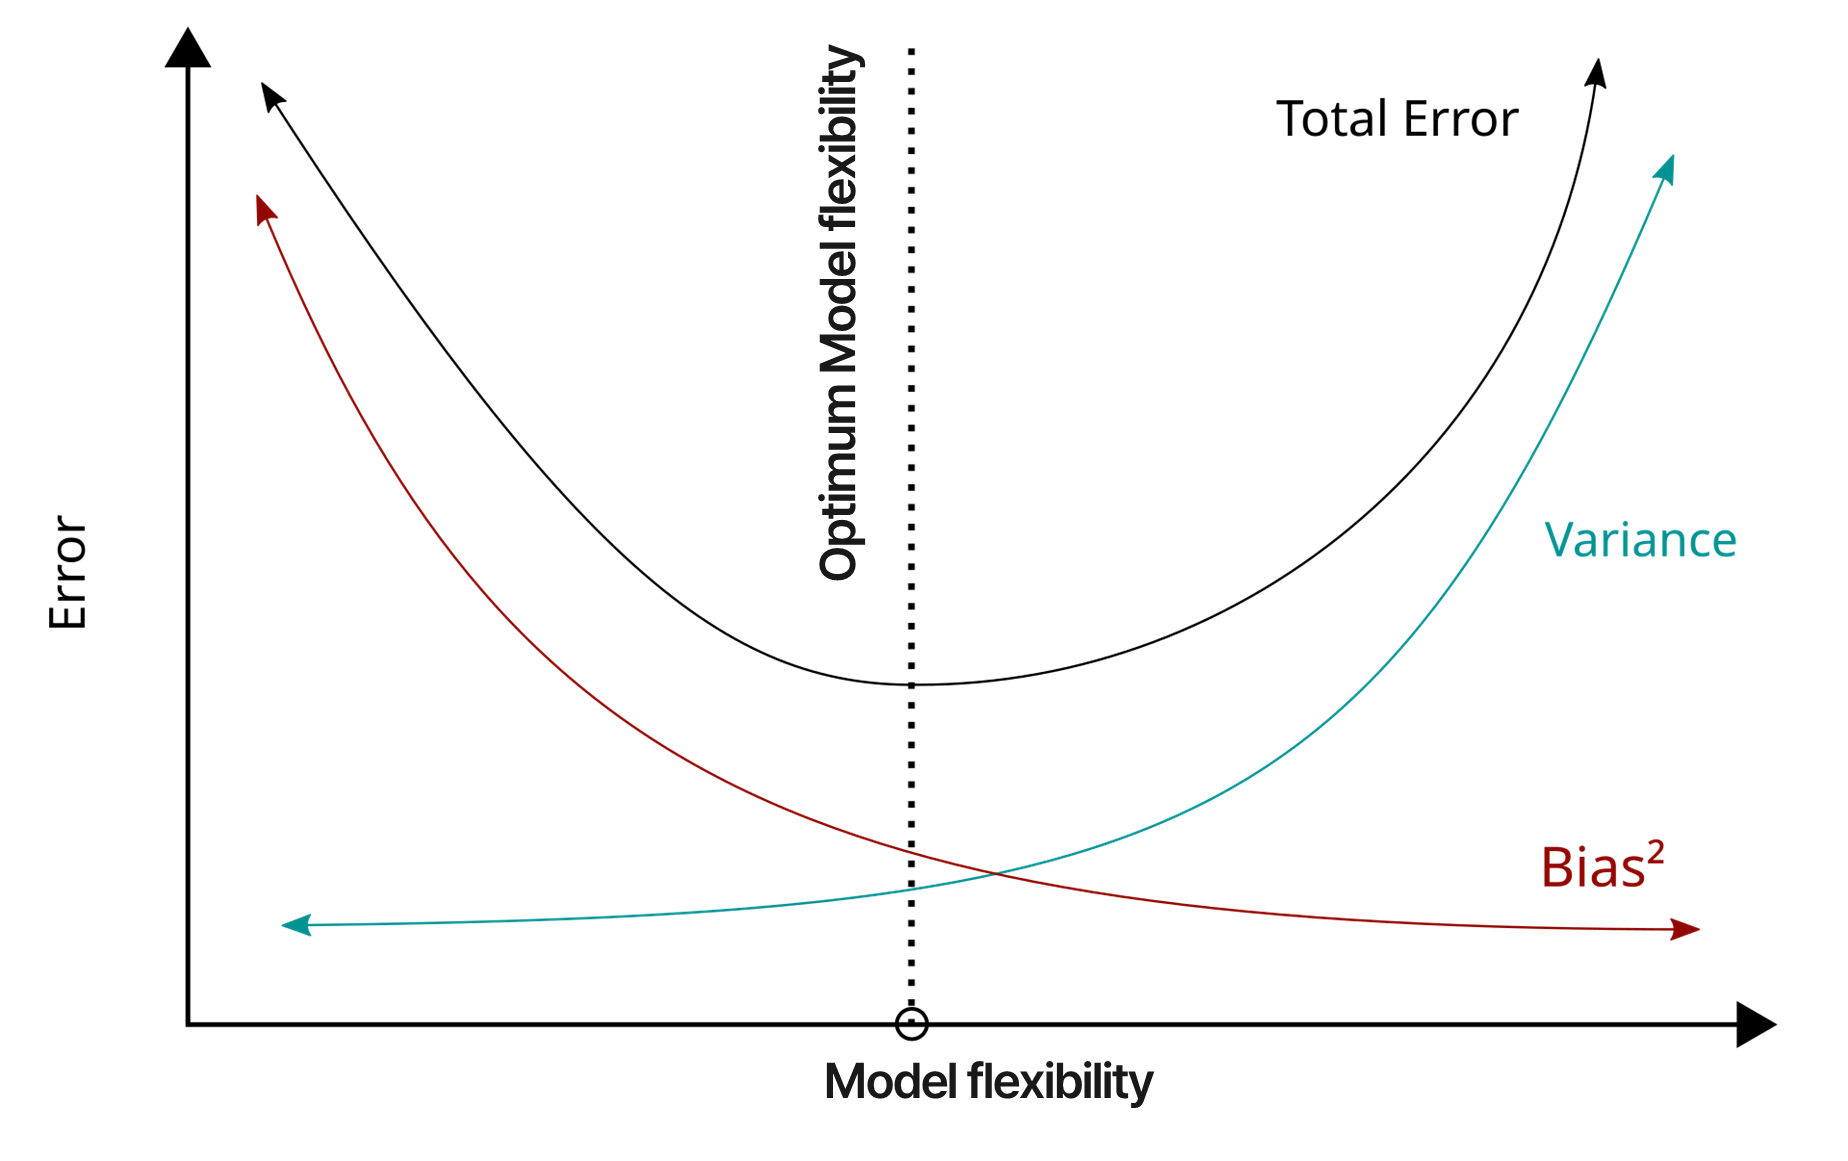

In [74]:
# reg_svr2: Baseline Tuning
# Holiday_yn을 추가해봅니다. 
# baseline 모델을 파라메터 튜닝을 합니다. : C, gamma

from sklearn.svm import SVR

ct = ColumnTransformer([
    ('std', StandardScaler(), ['TotalHour'] + ['lag_{}'.format(i) for i in range(1, 7)]),
    ('ohe', OneHotEncoder(categories='auto'), ['DayName']),
    ('pt', 'passthrough', ['AM'])
])
reg_svr2 = make_pipeline(ct, SVR(kernel = 'rbf', C = 1000, gamma = 0.2))
eval_model('reg_svr2', reg_svr2)

,result
name,
baseline,"Valid: 145.34694, Train: 59.43512"
reg_svr2,"Valid: 125.99554, Train: 30.55362"


In [75]:
prd = select_model(reg_svr2)
print("자가채점", mean_absolute_error(s_kaggle_ans, prd))

자가채점 32.90359337129784


In [81]:
from sklearn.preprocessing import PolynomialFeatures
ct = ColumnTransformer([
    ('std', make_pipeline(StandardScaler(), PolynomialFeatures(degree=2)), ['TotalHour'] + ['lag_{}'.format(i) for i in range(1, 7)]),
    ('ohe', OneHotEncoder(categories='auto'), ['DayName']),
    ('pt', 'passthrough', ['AM'])
])
reg_lr = make_pipeline(ct, LinearRegression())
eval_model('reg_lr', reg_lr)

,result
name,
baseline,"Valid: 145.34694, Train: 59.43512"
reg_lr,"Valid: 134.95890, Train: 73.26864"
reg_svr2,"Valid: 125.99554, Train: 30.55362"


In [99]:
import xgboost as xgb

X_xgb = "15분, 30분, 45분, 60분, Hour, AM, DayName, Weekend_yn, Holiday_yn, TotalHour, 생산량, 기온, 풍속, 습도, 강수량, 전기요금(계절), 공장인원, 인건비"
X_xgb = X_xgb.split(', ')
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories = 'auto'), ['DayName']),
    ('pt', 'passthrough', [i for i in X_xgb if i not in ['DayName']])
])
reg_xgb = make_pipeline(
    ct, xgb.XGBRegressor(max_depth=15, n_estimators = 300, learning_rate=0.075, reg_lambda = 2)
)
eval_model('reg_xgb', reg_xgb)

,result
name,
baseline,"Valid: 145.34694, Train: 59.43512"
reg_lr,"Valid: 134.95890, Train: 73.26864"
reg_svr2,"Valid: 125.99554, Train: 30.55362"
reg_xgb,"Valid: 88.75083, Train: 0.04680"


In [100]:
X_pca = ["15분", "30분", "45분", "60분", "TotalHour"]
df_train[X_pca].corr()

,15분,30분,45분,60분,TotalHour
15분,1.000000,0.978528,0.964361,0.946014,0.983474
30분,0.978528,1.000000,0.981661,0.955501,0.990656
45분,0.964361,0.981661,1.000000,0.982879,0.994421
60분,0.946014,0.955501,0.982879,1.000000,0.983375
TotalHour,0.983474,0.990656,0.994421,0.983375,1.000000


In [106]:
# XGB: XGBoost

import xgboost as xgb
from sklearn.decomposition import PCA

X_xgb = "15분, 30분, 45분, 60분, Hour, AM, DayName, Weekend_yn, Holiday_yn, TotalHour, 생산량, 기온, 풍속, 습도, 강수량, 전기요금(계절), 공장인원, 인건비"
X_xgb = X_xgb.split(', ')
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories = 'auto'), ['DayName']),
    ('std_pca', make_pipeline(StandardScaler(), PCA(n_components=2)), X_pca),
    ('pt', 'passthrough', [i for i in X_xgb if i not in ['DayName'] + X_pca])
])
reg_xgb2 = make_pipeline(
    ct, xgb.XGBRegressor(max_depth=15, n_estimators = 300, learning_rate=0.075, reg_lambda = 2)
)
eval_model('reg_xgb2', reg_xgb2)

,result
name,
baseline,"Valid: 145.34694, Train: 59.43512"
reg_lr,"Valid: 134.95890, Train: 73.26864"
reg_svr2,"Valid: 125.99554, Train: 30.55362"
reg_xgb,"Valid: 88.75083, Train: 0.04680"
reg_xgb2,"Valid: 84.70181, Train: 0.05880"


In [114]:
prd = select_model(reg_xgb2)
print("자가채점", mean_absolute_error(s_kaggle_ans, prd))

자가채점 38.11403752911475


In [113]:
# GBDT
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

X_gb = "15분, 30분, 45분, 60분, Hour, AM, DayName, Weekend_yn, Holiday_yn, TotalHour, 생산량, 기온, 풍속, 습도, 강수량, 전기요금(계절), 공장인원, 인건비"
X_gb = X_gb.split(', ')
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories = 'auto'), ['DayName']),
    ('std_pca', make_pipeline(StandardScaler(), PCA(n_components=2)), X_pca),
    ('pt', 'passthrough', [i for i in X_gb if i not in ['DayName'] + X_pca])
])

reg_gb = make_pipeline(
    ct, GradientBoostingRegressor(max_depth=None, max_leaf_nodes = 255, n_estimators = 100, random_state = 123)
)
eval_model('reg_gb', reg_gb)

,result
name,
baseline,"Valid: 145.34694, Train: 59.43512"
reg_gb,"Valid: 89.77483, Train: 2.77385"
reg_lr,"Valid: 134.95890, Train: 73.26864"
reg_svr2,"Valid: 125.99554, Train: 30.55362"
reg_xgb,"Valid: 88.75083, Train: 0.04680"
reg_xgb2,"Valid: 84.70181, Train: 0.05880"


In [123]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

X_rf = "15분, 30분, 45분, 60분, Hour, AM, DayName, Weekend_yn, Holiday_yn, TotalHour, 생산량, 기온, 풍속, 습도, 강수량, 전기요금(계절), 공장인원, 인건비"
X_rf = X_rf.split(', ')
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories = 'auto'), ['DayName']),
    ('std_pca', make_pipeline(StandardScaler(), PCA(n_components=2)), X_pca),
    ('pt', 'passthrough', [i for i in X_rf if i not in ['DayName'] + X_pca])
])

reg_rf = make_pipeline(
    ct, RandomForestRegressor(max_depth = 12, n_estimators = 150, random_state = 123)
)
eval_model('reg_rf', reg_rf)

,result
name,
baseline,"Valid: 145.34694, Train: 59.43512"
reg_gb,"Valid: 89.77483, Train: 2.77385"
reg_lr,"Valid: 134.95890, Train: 73.26864"
reg_rf,"Valid: 87.86149, Train: 32.45218"
reg_svr2,"Valid: 125.99554, Train: 30.55362"
reg_xgb,"Valid: 88.75083, Train: 0.04680"
reg_xgb2,"Valid: 84.70181, Train: 0.05880"


In [125]:
from sklearn.ensemble import VotingRegressor
reg_vt = VotingRegressor([
    #('reg_svr2', reg_svr2),
    #('reg_lr', reg_lr),
    ('reg_xgb2', reg_xgb2),
    #('reg_gb', reg_gb),
    ('reg_rf', reg_rf)
])
eval_model('reg_vt', reg_vt)

,result
name,
baseline,"Valid: 145.34694, Train: 59.43512"
reg_gb,"Valid: 89.77483, Train: 2.77385"
reg_lr,"Valid: 134.95890, Train: 73.26864"
reg_rf,"Valid: 87.86149, Train: 32.45218"
reg_svr2,"Valid: 125.99554, Train: 30.55362"
reg_vt,"Valid: 85.61826, Train: 16.24543"
reg_xgb,"Valid: 88.75083, Train: 0.04680"
reg_xgb2,"Valid: 84.70181, Train: 0.05880"
